## 消费者的基本概念与使用

与生产者对应的是消费者，应用程序可以通过 KafkaConsumer 订阅主题，并从订阅的主题中拉取消息

### 消费者与消费组
与其他一些消息中间件不同的是：在 Kafka 的消费者理念上还有一层消费组（Consumer Group）的概念，每个消费者都有一个对应的消费组，每个消费组之间互不影响，独立消费主题中的信息

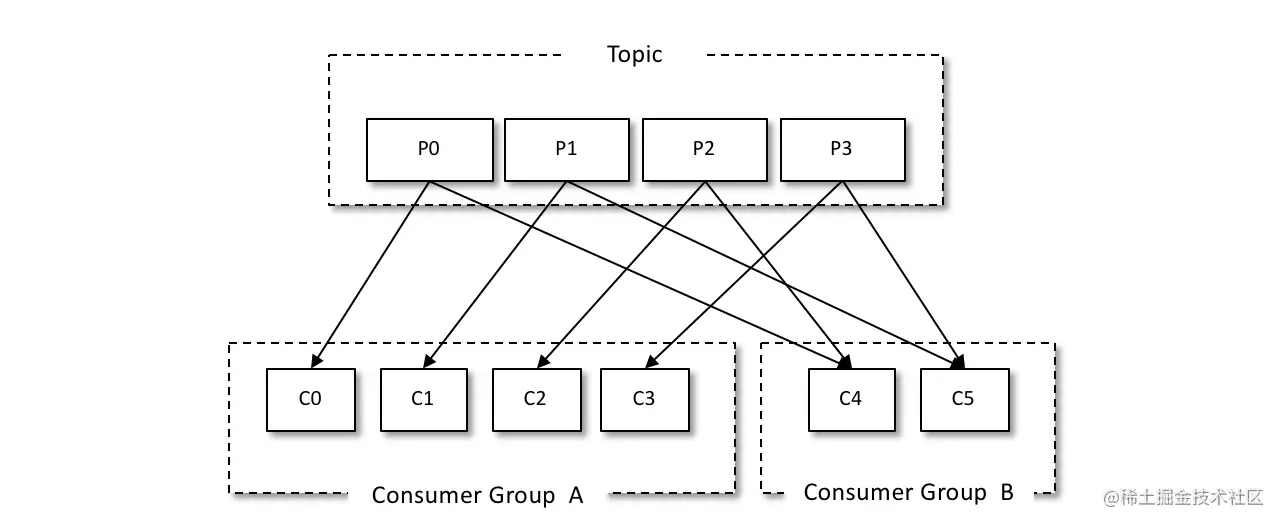

如上图所示，某个主题中共有4个分区（Partition）：P0、P1、P2、P3。有两个消费组A和B都订阅了这个主题，消费组A中有4个消费者（C0、C1、C2和C3），消费组B中有2个消费者（C4和C5）。按照 Kafka 默认的规则，最后的分配结果是消费组A中的每一个消费者分配到1个分区，消费组B中的每一个消费者分配到2个分区，两个消费组之间互不影响。每个消费者消费所分配到的分区中的消息。换言之，**每一个分区只能被一个消费组中的一个消费者所消费**

一般有两种消息投递模式：点对点（P2P，Point-to-Point）模式和发布/订阅（Pub/Sub）模式。

* 点对点模式是基于队列的，消息生产者发送消息到队列，消息消费者从队列中接收消息
* 发布订阅模式定义了如何向一个内容节点发布和订阅消息，这个内容节点称为主题（Topic），主题可以认为是消息传递的中介，消息发布者将消息发布到某个主题，而消息订阅者从主题中订阅消息。

kafka 借助消费组的概念可以同时支持两种模式的消息订阅模式：
* 如果所有的消费者都隶属于同一个消费组，那么所有的消息都会被均衡地投递给每一个消费者，即每条消息只会被一个消费者处理，这就相当于点对点模式的应用。
* 
如果所有的消费者都隶属于不同的消费组，那么所有的消息都会被广播给所有的消费者，即每条消息会被所有的消费者处理，这就相当于发布/订阅模式的应用。


### 消费者客户端的使用

一个正常的消费逻辑需要具备以下几个步骤：

1. 配置消费者客户端参数及创建相应的消费者实例，并订阅主题
3. 拉取消息并消费
4. 提交消费位移
5. 关闭消费者实例

In [2]:
topic = "test_topic"

from kafka import KafkaConsumer

KafkaConsumer?

Init signature: KafkaConsumer(*topics, **configs)
Docstring:     
Consume records from a Kafka cluster.

The consumer will transparently handle the failure of servers in the Kafka
cluster, and adapt as topic-partitions are created or migrate between
brokers. It also interacts with the assigned kafka Group Coordinator node
to allow multiple consumers to load balance consumption of topics (requires
kafka >= 0.9.0.0).

The consumer is not thread safe and should not be shared across threads.

Arguments:
    *topics (str): optional list of topics to subscribe to. If not set,
        call :meth:`~kafka.KafkaConsumer.subscribe` or
        :meth:`~kafka.KafkaConsumer.assign` before consuming records.

Keyword Arguments:
    bootstrap_servers: 'host[:port]' string (or list of 'host[:port]'
        strings) that the consumer should contact to bootstrap initial
        cluster metadata. This does not have to be the full node list.
        It just needs to have at least one broker that will respon

In [3]:
# 创建消费者（具体参数细则请查看文档）
import json 
consumer = KafkaConsumer(topic, 
                         bootstrap_servers=["kafka1:9092"], 
                         group_id='my-group',
                         value_deserializer=lambda v: json.loads(v.decode()),
                         auto_offset_reset='earliest',
                         enable_auto_commit=True,
                         auto_commit_interval_ms=1000)

In [ ]:
# 拉取消息并消费
for message in consumer:
    value = message.value
    headers = message.headers
    # 处理消息
    print(value, message.)
    for header in headers:
        print(header[0], header[1])

#### 手动提交位移 
```python
#提交当前消费者组中所有分区的位移
consumer.commit()
# 支持提交特定分区的位移，可以将分区信息作为参数传递给commit()方法
consumer.commit({TopicPartition('my_topic', 0): OffsetAndMetadata(1234, None)})
# 提交my_topic主题下第0个分区的位移为1234的消息的位移信息
```

In [4]:
#关闭消费者
consumer.close?

Signature: consumer.close(autocommit=True)
Docstring:
Close the consumer, waiting indefinitely for any needed cleanup.

Keyword Arguments:
    autocommit (bool): If auto-commit is configured for this consumer,
        this optional flag causes the consumer to attempt to commit any
        pending consumed offsets prior to close. Default: True
File:      /opt/conda/lib/python3.11/site-packages/kafka/consumer/group.py
Type:      method

#### 注意！！！

消费者会有重复消费和消息丢失的风险，给出工程界的解决方案 [如何保证kafka无消息丢失](https://mp.weixin.qq.com/s/MzGnUHRDWihYFT4epAXOOw)

## 再均衡器与拦截器

### 再均衡器
再均衡是指分区的所属权从一个消费者转移到另一消费者的行为，它为消费组具备高可用性和伸缩性提供保障，使我们可以既方便又安全地删除消费组内的消费者或往消费组内添加消费者

当一个分区被重新分配给另一个消费者时，消费者当前的状态也会丢失。比如消费者消费完某个分区中的一部分消息时还没有来得及提交消费位移就发生了再均衡操作，之后这个分区又被分配给了消费组内的另一个消费者，原来被消费完的那部分消息又被重新消费一遍，可能会导致重复消费

### 拦截器
费者拦截器主要在消费到消息或在提交消费位移时进行一些定制化的操作，

In [ ]:
from kafka import KafkaConsumer, ConsumerRebalanceListener

class MyConsumerInterceptor(object):
    def __init__(self):
        pass
    
    def on_consume(self, message):
        # 在消息被消费者消费之前，对消息进行定制化操作
        return message
    
    def on_commit(self, message):
        # 会在提交完消费位移之后调用拦截器的 onCommit() 方法
        return message

class MyConsumerRebalanceListener(ConsumerRebalanceListener):
    def __init__(self):
        pass
    
    def on_partitions_revoked(partitions):
        # 在分区再平衡之前，将分区的偏移量提交到Kafka集群
        for partition in partitions:
            consumer.commit(offsets={TopicPartition(partition.topic, partition.partition): partition.offset})

    def on_partitions_assigned(partitions):
        # 在分区重新分配之后，输出分配给当前消费者的分区信息
        print('Partitions assigned:', partitions)

consumer = KafkaConsumer(
    'my_topic',
    bootstrap_servers=['localhost:9092'],
    auto_offset_reset='earliest',
    enable_auto_commit=True,
    group_id='my-group',
    interceptor_classes=[MyConsumerInterceptor],
    listener=MyConsumerRebalanceListener()
)

for message in consumer:
    print(message)
